![AIcrowd-Logo](https://raw.githubusercontent.com/AIcrowd/AIcrowd/master/app/assets/images/misc/aicrowd-horizontal.png)

This dataset and notebook correspond to the [MASKD Challenge](https://www.aicrowd.com/challenges/aicrowd-blitz-2/problems/maskd) being held on [AIrowd](https://www.aicrowd.com/).

# Downloads and Installations

In [ ]:
# download the MaskRCNN repository
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.76 MiB | 38.32 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [ ]:
# install
!cd Mask_RCNN; python setup.py install

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn

In [ ]:
!cd Mask_RCNN; wget -q https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [ ]:
# install pycocotools
!pip uninstall -q pycocotools -y
!pip install -q git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI
# install a stable version of numpy
!pip install -q numpy==1.17.0

     |████████████████████████████████| 20.4MB 1.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


**Restart Runtime** here!

In [ ]:
# install a stable keras version
!pip install -q keras==2.2.5

     |████████████████████████████████| 337kB 2.9MB/s 


DOWNLOAD DATASET

In [ ]:
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/maskd/v0.1/train_images.zip
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/maskd/v0.1/val_images.zip
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/maskd/v0.1/test_images.zip

In [ ]:
!unzip -q train_images.zip
!unzip -q val_images.zip
!unzip -q test_images.zip

In [ ]:
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/maskd/v0.1/train.json
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/maskd/v0.1/val.json
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/maskd/v0.1/test.json

# Imports

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
import matplotlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
import imgaug.augmenters as iaa

from matplotlib.patches import Polygon
from collections import OrderedDict
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils


# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config

%matplotlib inline

Using TensorFlow backend.


# Explanatory Data Analysis

Let us Inspect the data we have first before moving on to building the model.

In [ ]:
##Create Mask Dataset Class
class MaskDataset(utils.Dataset):
    def load_dataset(self, dataset_dir,dtype,return_coco=True):
        """ Loads Mask dataset
            Params:
                - dataset_dir : root directory of the dataset (can point to the train/val folder)
                - dtype: specifies train or val
                - load_small : Boolean value which signals if the annotations for all the images need to be loaded into the memory,
                               or if only a small subset of the same should be loaded into memory
        """
        self.dtype = dtype
        if self.dtype=="train":
          annotation_path = os.path.join(dataset_dir, "train.json")
          image_dir = os.path.join(dataset_dir, "train_images")
        elif self.dtype=="val":
          annotation_path = os.path.join(dataset_dir, "val.json")
          image_dir = os.path.join(dataset_dir, "val_images")

        print("Annotation Path ", annotation_path)
        print("Image Dir ", image_dir)
        assert os.path.exists(annotation_path) and os.path.exists(image_dir)

        self.coco = COCO(annotation_path)
        self.image_dir = image_dir

        # Load all classes (Only Building in this version)
        classIds = self.coco.getCatIds()

        # Load all images
        image_ids = list(self.coco.imgs.keys())

        # register classes
        for _class_id in classIds:
            self.add_class("mask-detection", _class_id, self.coco.loadCats(_class_id)[0]["name"])

        # Register Images
        for _img_id in image_ids:
            assert(os.path.exists(os.path.join(image_dir, self.coco.imgs[_img_id]['file_name'])))
            self.add_image(
                "mask-detection", image_id=_img_id,
                path=os.path.join(image_dir, self.coco.imgs[_img_id]['file_name']),
                width=self.coco.imgs[_img_id]["width"],
                height=self.coco.imgs[_img_id]["height"],
                annotations=self.coco.loadAnns(self.coco.getAnnIds(
                                            imgIds=[_img_id],
                                            catIds=classIds,
                                            iscrowd=None)))

        if return_coco:
            return self.coco

    def load_mask(self, image_id):
        """ Loads instance mask for a given image
              This function converts mask from the coco format to a
              a bitmap [height, width, instance]
            Params:
                - image_id : reference id for a given image

            Returns:
                masks : A bool array of shape [height, width, instances] with
                    one mask per instance
                class_ids : a 1D array of classIds of the corresponding instance masks
        """

        image_info = self.image_info[image_id]
        assert image_info["source"] == "mask-detection"

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "mask-detection.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation,  image_info["height"],
                                                image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue

                # Ignore the notion of "is_crowd" as specified in the coco format
                # as we donot have the said annotation in the current version of the dataset

                instance_masks.append(m)
                class_ids.append(class_id)
        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(MaskDataset, self).load_mask(image_id)


    def image_reference(self, image_id):
        """Return a reference for a particular image

            Ideally you this function is supposed to return a URL
            but in this case, we will simply return the image_id
        """
        return "mask-detection::{}".format(image_id)
    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

The MaskRCNN repository works on configs. For trainin we create a config sa shown below.

In [ ]:
class MaskConfig(Config):
    """Configuration for training on data in MS COCO format.
    Derives from the base Config class and overrides values specific
    to the COCO dataset. Edit here to find optimum parameters
    """
    # Give the configuration a recognizable name
    NAME = "mask-detection"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Comment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1

    BACKBONE = 'resnet50'
    
    # Number of classes (including background)
    NUM_CLASSES = 3  # 1 Background + 2 classes(mask/no_mask)

    STEPS_PER_EPOCH=150
    VALIDATION_STEPS=50
    MAX_GT_INSTANCES=35
    LEARNING_RATE=0.001
    IMAGE_MAX_DIM=256
    IMAGE_MIN_DIM=256
    MINI_MASK_SHAPE=(128,128)


In [ ]:
# Mask Dataset 
config = MaskConfig()
DATASET_DIR = "/content/"

In [ ]:
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [ ]:
dataset = MaskDataset()
dataset.load_dataset(DATASET_DIR, "train")
# Must call before using the dataset
dataset.prepare()

print("[INFO] Image Count: {}".format(len(dataset.image_ids)))
print("[INFO] Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Annotation Path  /content/train.json
Image Dir  /content/train_images
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
[INFO] Image Count: 679
[INFO] Class Count: 3
  0. BG                                                
  1. mask                                              
  2. no_mask                                           



## Samples

Load and display some sample images and masks.


[INFO] Image ID: 239


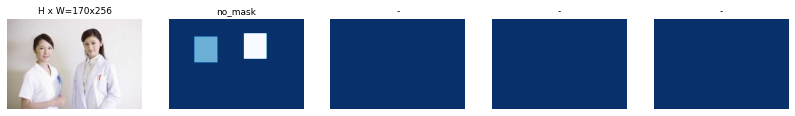

[INFO] Image ID: 362


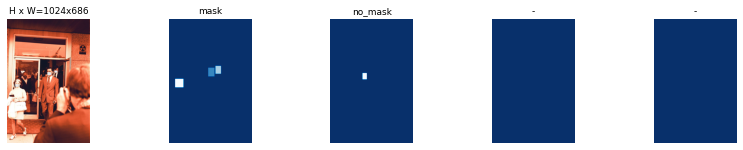

[INFO] Image ID: 435


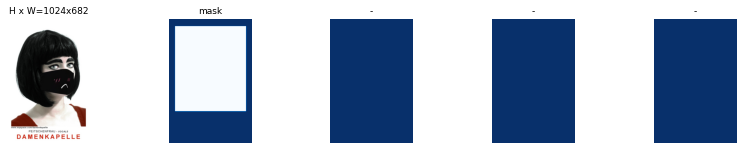

[INFO] Image ID: 629


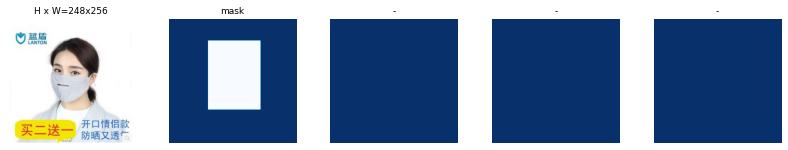

In [ ]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    print("[INFO] Image ID: {}".format(image_id))
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)


## Bounding Boxes

Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updated masks rather than computing bounding box transformation for each type of image transformation.


[INFO] Image Shape: (768, 1024, 2) 	Class ID : [2 2]
[INFO] Image ID: 75 	Dataset Reference: mask-detection::75
[INFO] Image             shape: (768, 1024, 3)        min:    0.00000  max:  255.00000  uint8
[INFO] Mask              shape: (768, 1024, 2)        min:    0.00000  max:    1.00000  uint8
[INFO] Class IDs         shape: (2,)                  min:    2.00000  max:    2.00000  int32
[INFO] BBOX              shape: (2, 4)                min:   69.00000  max:  480.00000  int32


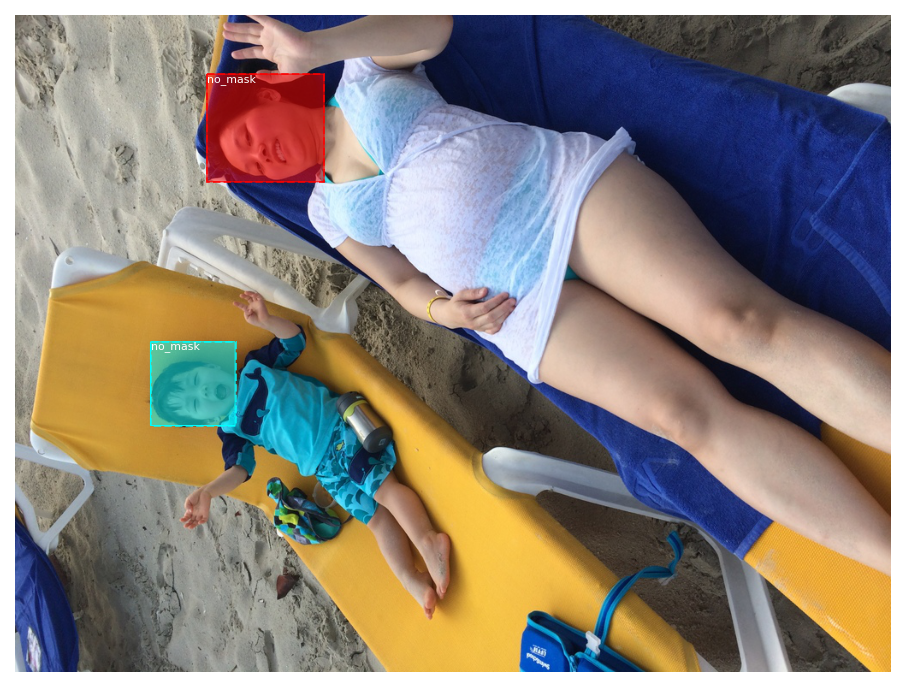

In [ ]:
# Load random image and mask.
image_id =  np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
print("[INFO] Image Shape: {} \tClass ID : {}".format(mask.shape, class_ids))
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("[INFO] Image ID: {} \tDataset Reference: {}".format(image_id, dataset.image_reference(image_id)))
log("[INFO] Image", image)
log("[INFO] Mask", mask)
log("[INFO] Class IDs", class_ids)
log("[INFO] BBOX", bbox)

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)


## Resize Images

To support multiple images per batch, images are resized to one size (256x256). However aspect ratio is preserved. If an image is not square, then zero padding is added at the top/bottom or right/left.


[INFO] Image ID: 566 	Dataset Reference: mask-detection::566
[INFO] Original Shape:  (220, 220, 3)
[INFO] Image             shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
[INFO] Mask              shape: (256, 256, 1)         min:    0.00000  max:    1.00000  uint8
[INFO] Class IDs         shape: (1,)                  min:    1.00000  max:    1.00000  int32
[INFO] BBOX              shape: (1, 4)                min:   13.00000  max:  172.00000  int32


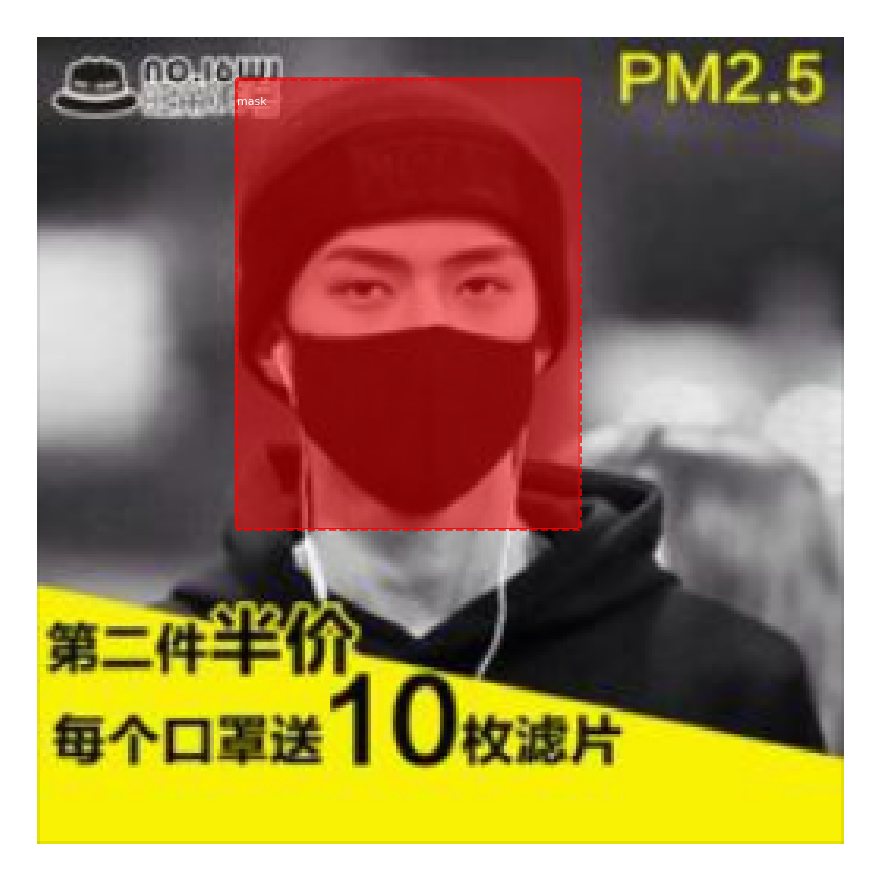

In [ ]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape

# Resize
image, window, scale, padding, _ = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("[INFO] Image ID: {} \tDataset Reference: {}".format(image_id, dataset.image_reference(image_id)))
print("[INFO] Original Shape: ", original_shape)
log("[INFO] Image", image)
log("[INFO] Mask", mask)
log("[INFO] Class IDs", class_ids)
log("[INFO] BBOX", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)


## Mini Masks

Instance binary masks can get large when training with high resolution images. For example, if training with 1024x1024 image then the mask of a single instance requires 1MB of memory (Numpy uses bytes for boolean values). If an image has 100 instances then that's 100MB for the masks alone.

To improve training speed, masks are optimized as:

* Mask pixels that are inside the object bounding box are stored, rather than a mask of the full image. Most objects are small compared to the image size, so space is saved by not storing a lot of zeros around the object.
* The mask is resized to a smaller size (e.g. 56x56). For objects that are larger than the selected size we lose a bit of accuracy. However, this loss is negligable for most practical purposes. Thie size of the mini_mask can be set in the config class.

To visualize the effect of mask resizing, and to verify the code correctness, we visualize some examples.



[INFO] Image             shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
[INFO] Class IDs         shape: (3,)                  min:    1.00000  max:    1.00000  int32
[INFO] BBOX              shape: (3, 4)                min:   63.00000  max:  184.00000  int32
[INFO] Mask              shape: (256, 256, 3)         min:    0.00000  max:    1.00000  uint8
[INFO] Image Metas       shape: (15,)                 min:    0.00000  max:  256.00000  float64


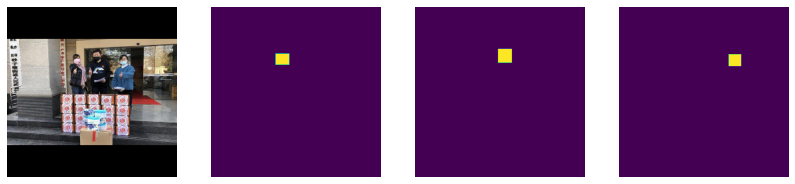

In [ ]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("[INFO] Image", image)
log("[INFO] Class IDs", class_ids)
log("[INFO] BBOX", bbox)
log("[INFO] Mask", mask)
log("[INFO] Image Metas", image_meta)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

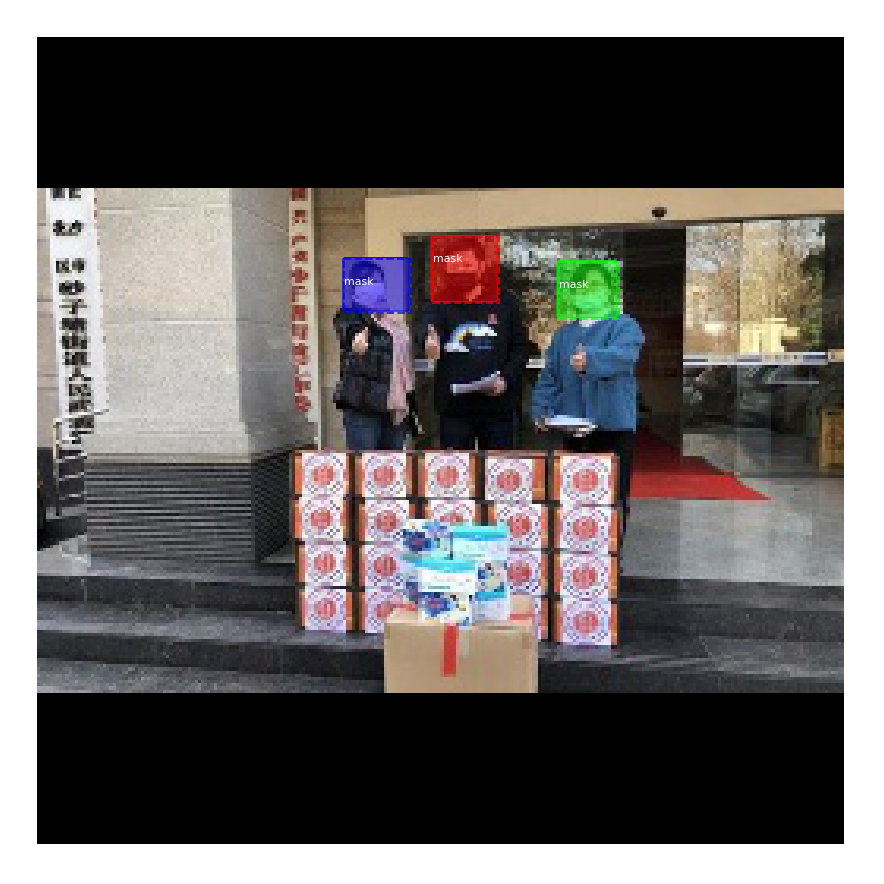

In [ ]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Augmentations

Image augmentation is a strategy that allows us to significantly increase the diversity of images available for training models, without actually collecting new images. Augmentations make the model more robust.

[INFO] Mask              shape: (256, 256, 3)         min:    0.00000  max:    1.00000  bool


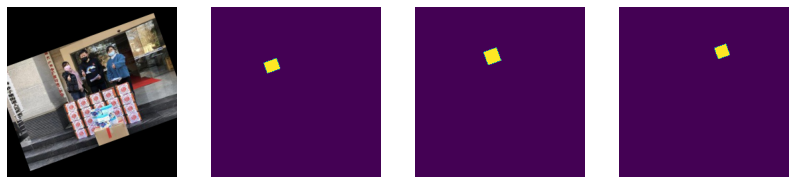

In [ ]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset,
    config,
    image_id,
    augmentation=iaa.Affine(rotate=(-35, 35)),
    use_mini_mask=False
  )

log("[INFO] Mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

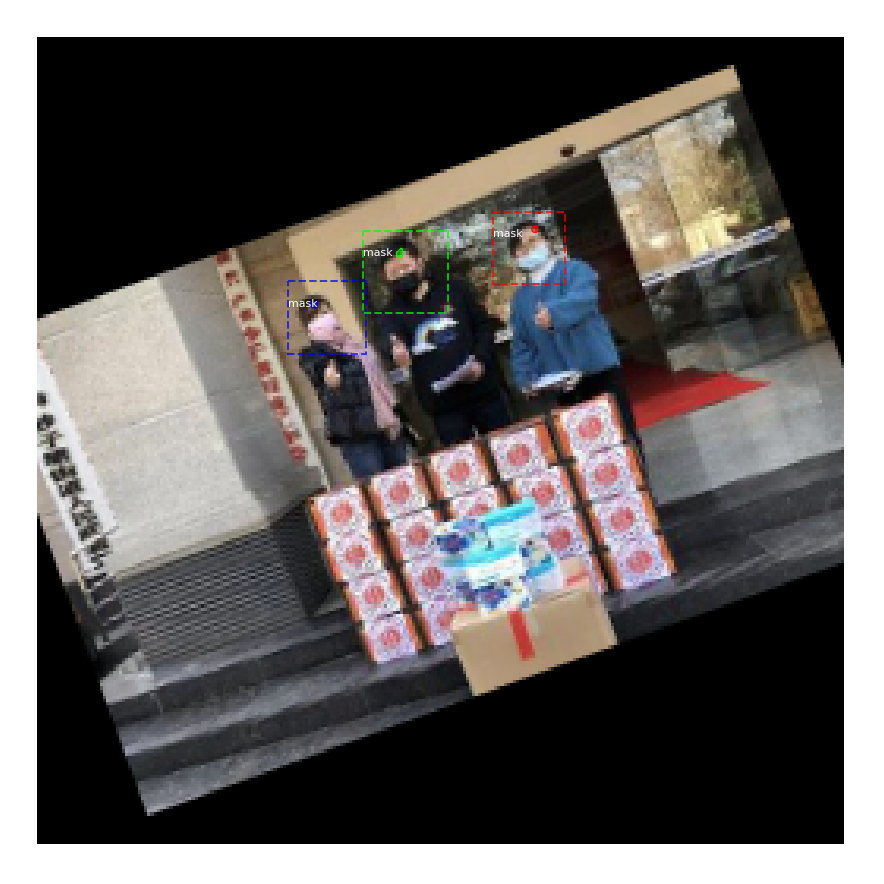

In [ ]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

# Anchors, Feature Pyramid Network and ROIs

Detecting objects at different scales is challenging, even more so for small objects. We can use a pyramid of the same image at different scale to detect objects, as shown below. However this is a compute costly process and hence isn't used often. Alternatively, we create a pyramid of feature and use them for object detection.

![](https://github.com/RohitMidha23/Explained/blob/master/images/FPN.png?raw=True)

<center><a href="https://arxiv.org/pdf/1612.03144.pdf">Source</a></center>

For an Feature Pyramid Network (FPN) network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 

The order of anchors is important. The same order has to be used in training and prediction phases. This must also match the order of the convolution execution. This is internally taken care of by the MaskRCNN library.

* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row.
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

**Anchor Stride:** In the FPN architecture, feature maps at the first few layers are high resolution. For example, if the input image is 1024x1024 then the feature map of the first layer is 256x256, which generates about 200K anchors (256x256x3). These anchors are 32x32 pixels and their stride relative to image pixels is 4 pixels, so there is a lot of overlap. We can reduce the load significantly if we generate anchors for every other cell in the feature map. A stride of 2 will cut the number of anchors by 4, for example.

In this implementation we use an anchor stride of 2, which is different from the paper.


In [ ]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(
    config.RPN_ANCHOR_SCALES, 
    config.RPN_ANCHOR_RATIOS,
    backbone_shapes,
    config.BACKBONE_STRIDES, 
    config.RPN_ANCHOR_STRIDE
  )

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("[INFO] Anchors Count: ", anchors.shape[0])
print("[INFO] Scales: ", config.RPN_ANCHOR_SCALES)
print("[INFO] Ratios: ", config.RPN_ANCHOR_RATIOS)
print("[INFO] Anchors per Cell: ", anchors_per_cell)
print("[INFO] Levels: ", num_levels)

anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors at Level {}: {}".format(l, anchors_per_level[l]))

[INFO] Anchors Count:  16368
[INFO] Scales:  (32, 64, 128, 256, 512)
[INFO] Ratios:  [0.5, 1, 2]
[INFO] Anchors per Cell:  3
[INFO] Levels:  5
Anchors at Level 0: 12288
Anchors at Level 1: 3072
Anchors at Level 2: 768
Anchors at Level 3: 192
Anchors at Level 4: 48




Visualize anchors of one cell at the center of the feature map of a specific level.


Level 0. Anchors:  12288  Feature map Shape: [64 64]
Level 1. Anchors:   3072  Feature map Shape: [32 32]
Level 2. Anchors:    768  Feature map Shape: [16 16]
Level 3. Anchors:    192  Feature map Shape: [8 8]
Level 4. Anchors:     48  Feature map Shape: [4 4]


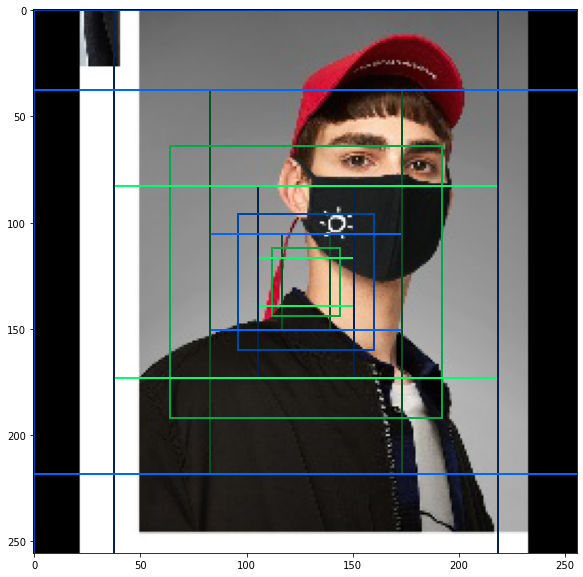

In [ ]:
# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                  backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

## Data Generator

In [ ]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [ ]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("[INFO] rois", rois)
    log("[INFO] mrcnn_class_ids", mrcnn_class_ids)
    log("[INFO] mrcnn_bbox", mrcnn_bbox)
    log("[INFO] mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("[INFO] gt_class_ids", gt_class_ids)
log("[INFO] gt_boxes", gt_boxes)
log("[INFO] gt_masks", gt_masks)
log("[INFO] rpn_match", rpn_match, )
log("[INFO] rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("[INFO] Image ID: {} \tDataset Reference: {}".format(image_id, dataset.image_reference(image_id)))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

[INFO] rois              shape: (4, 200, 4)           min:    0.00000  max:  255.00000  int32
[INFO] mrcnn_class_ids   shape: (4, 200, 1)           min:    0.00000  max:    2.00000  int32
[INFO] mrcnn_bbox        shape: (4, 200, 3, 4)        min:   -3.97727  max:    3.07143  float32
[INFO] mrcnn_mask        shape: (4, 200, 28, 28, 3)   min:    0.00000  max:    1.00000  float32
[INFO] gt_class_ids      shape: (4, 35)               min:    0.00000  max:    2.00000  int32
[INFO] gt_boxes          shape: (4, 35, 4)            min:    0.00000  max:  223.00000  int32
[INFO] gt_masks          shape: (4, 128, 128, 35)     min:    0.00000  max:    1.00000  bool
[INFO] rpn_match         shape: (4, 16368, 1)         min:   -1.00000  max:    1.00000  int32
[INFO] rpn_bbox          shape: (4, 256, 4)           min:   -2.22656  max:    1.79688  float64
[INFO] Image ID: 410 	Dataset Reference: mask-detection::410


anchors                  shape: (16368, 4)            min: -362.03867  max:  554.03867  float64
refined_anchors          shape: (5, 4)                min:   45.99999  max:  184.00002  float32
Positive anchors: 5
Negative anchors: 251
Neutral anchors: 16112
BG                     : 148
mask                   : 52


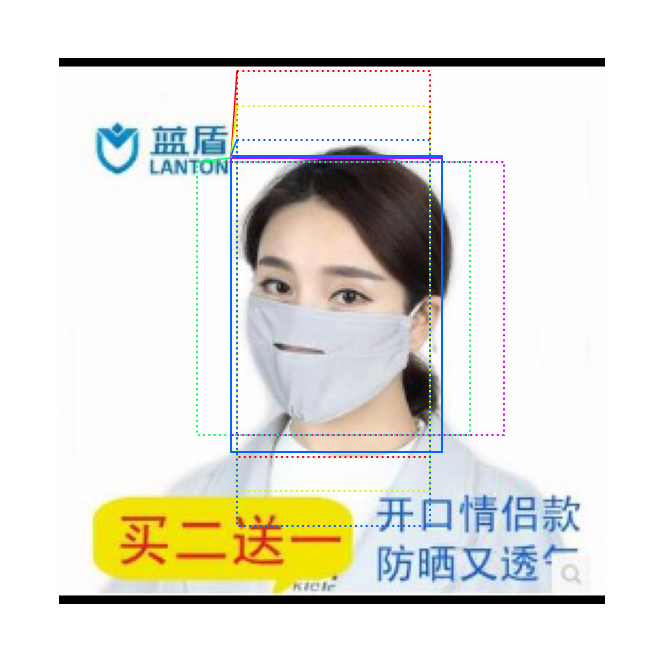

In [ ]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

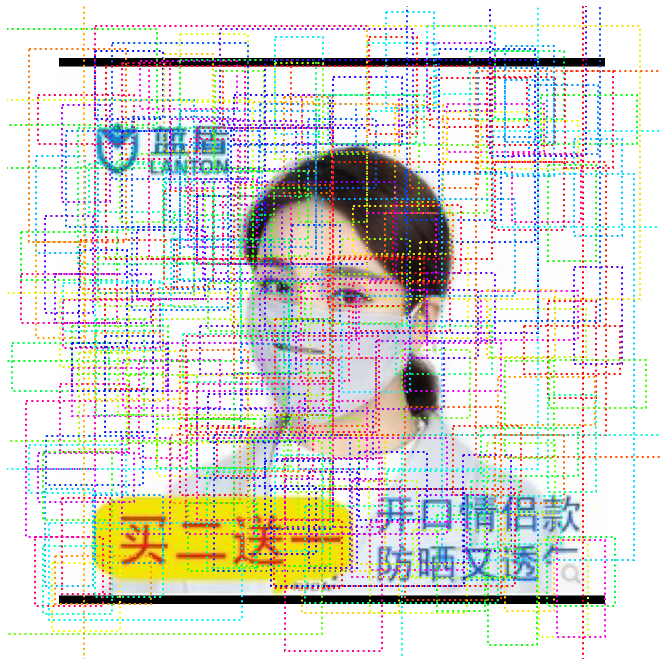

In [ ]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

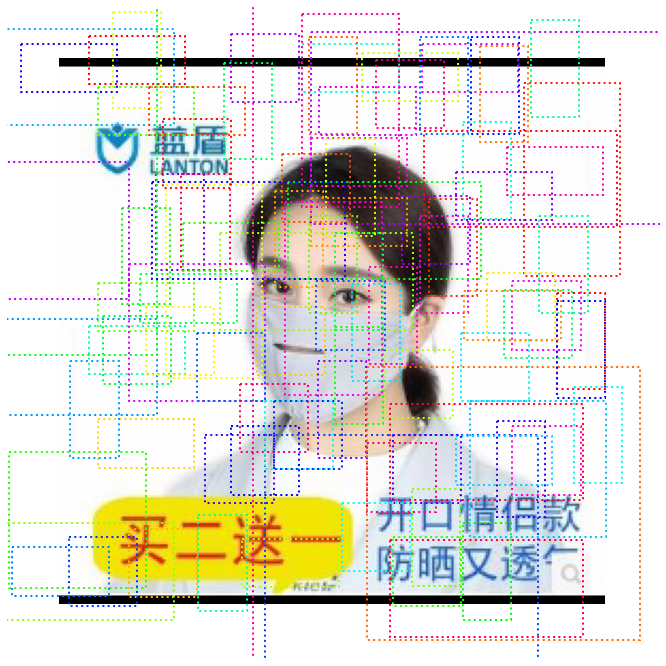

In [ ]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Positive ROIs:  52
Negative ROIs:  148
Positive Ratio: 0.26
Unique ROIs: 200 out of 200


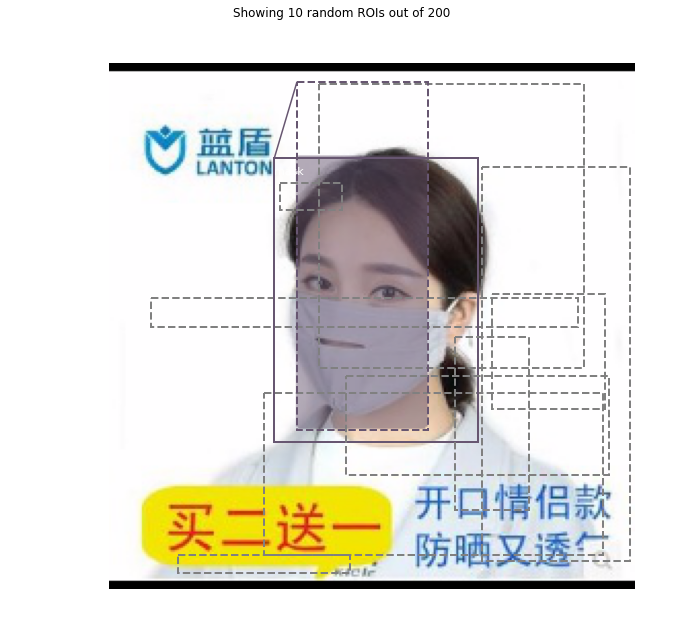

In [ ]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

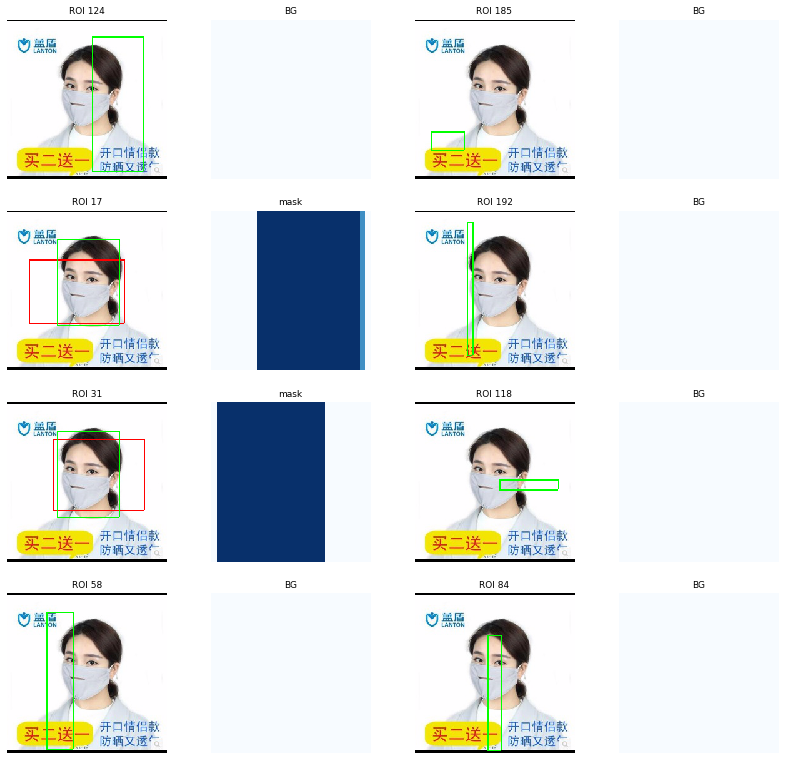

In [ ]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [ ]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
   66  0.33
Average percent: 0.33


# Training

In [ ]:
dataset_train = MaskDataset()
dataset_train.load_dataset(DATASET_DIR,"train")
dataset_train.prepare()

Annotation Path  /content/train.json
Image Dir  /content/train_images
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
dataset_val = MaskDataset()
val_coco = dataset_val.load_dataset(DATASET_DIR,"val")
dataset_val.prepare()

Annotation Path  /content/val.json
Image Dir  /content/val_images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

Loading Mask R-CNN model...


In [ ]:
#load the weights for COCO
model.load_weights('mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
print("Training network")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=13,
            layers='heads')

Training network

Starting at epoch 0. LR=0.001

Checkpoint Path: ./mask-detection20200602T0923/mask_rcnn_mask-detection_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mr

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/13
150/150 [==============================] - 117s 782ms/step - loss: 1.6932 - rpn_class_loss: 0.0853 - rpn_bbox_loss: 0.6599 - mrcnn_class_loss: 0.1438 - mrcnn_bbox_loss: 0.4592 - mrcnn_mask_loss: 0.3449 - val_loss: 1.3858 - val_rpn_class_loss: 0.0800 - val_rpn_bbox_loss: 0.5618 - val_mrcnn_class_loss: 0.0964 - val_mrcnn_bbox_loss: 0.3261 - val_mrcnn_mask_loss: 0.3215

Epoch 2/13
150/150 [==============================] - 86s 576ms/step - loss: 1.1536 - rpn_class_loss: 0.0491 - rpn_bbox_loss: 0.4359 - mrcnn_class_loss: 0.1037 - mrcnn_bbox_loss: 0.2746 - mrcnn_mask_loss: 0.2904 - val_loss: 1.1483 - val_rpn_class_loss: 0.0382 - val_rpn_bbox_loss: 0.4040 - val_mrcnn_class_loss: 0.0945 - val_mrcnn_bbox_loss: 0.3111 - val_mrcnn_mask_loss: 0.3005
Epoch 3/13
150/150 [==============================] - 88s 584ms/step - loss: 1.0625 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.3813 - mrcnn_class_loss: 0.0855 - mrcnn_bbox_loss: 0.2592 - mrcnn_mask_loss: 0.2930 - val_loss: 1.1236 - val_r

In [ ]:
model_path = model.find_last()
model_path

'./mask-detection20200602T0923/mask_rcnn_mask-detection_0013.h5'

# Inference

In [ ]:
class InferenceConfig(MaskConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 3  # 1 Background + 61 classes
    IMAGE_MAX_DIM=256
    IMAGE_MIN_DIM=256
    NAME = "mask-detection"
    DETECTION_MIN_CONFIDENCE=0.8
    
inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [ ]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir="./")

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./mask-detection20200602T0923/mask_rcnn_mask-detection_0013.h5
Re-starting from epoch 13


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


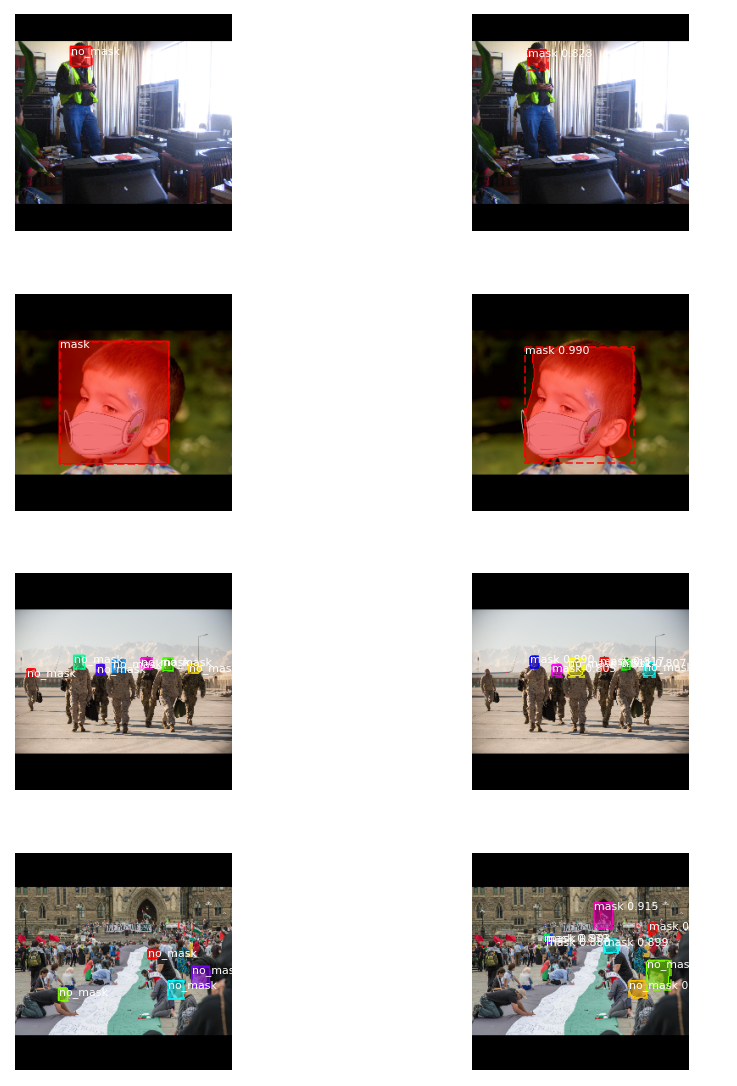

In [ ]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(15, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names, ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=fig.axes[-1])

In [ ]:
import json
with open(DATASET_DIR+'/val.json') as json_file:
    data = json.load(json_file)

In [ ]:
d = {}
for x in data["categories"]:
    d[x["name"]]=x["id"]

In [ ]:
d

{'mask': 1, 'no_mask': 2}

In [ ]:
id_category = [0]
for x in dataset.class_names[1:]:
    id_category.append(d[x])
id_category

[0, 1, 2]

In [ ]:
val_images_map_id={}
for x in data["images"]:
  val_images_map_id[x["file_name"]]=x["id"]

In [ ]:
from tqdm.notebook import tqdm
import skimage
import glob

In [ ]:
files = os.listdir(DATASET_DIR+'val_images')
_final_object = []
for f in tqdm(files,total=len(files)):
  try:
    images = [skimage.io.imread(DATASET_DIR+'val_images/'+f) ]
    #if(len(images)!= inference_config.IMAGES_PER_GPU):
    #    images = images + [images[-1]]*(inference_config.BATCH_SIZE - len(images))
    predictions = model.detect(images, verbose=0)
    #print(file)
    for _idx, r in enumerate(predictions):
          
              image_id = f.split(".")[0]
              for _idx, class_id in enumerate(r["class_ids"]):
                  if class_id > 0:
                      mask = r["masks"].astype(np.uint8)[:, :, _idx]
                      bbox = np.around(r["rois"][_idx], 1)
                      bbox = [float(x) for x in bbox]
                      _result = {}
                      _result["image_id"] = val_images_map_id[f]
                      _result["category_id"] = id_category[class_id]
                      _result["score"] = float(r["scores"][_idx])
                      _mask = maskUtils.encode(np.asfortranarray(mask))
                      _mask["counts"] = _mask["counts"].decode("UTF-8")
                      _result["segmentation"] = _mask
                      _result["bbox"] = [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]]
                      _final_object.append(_result)
      
    
  except:
    print("Error with",f)
    continue

fp = open('/content/output.json', "w")
import json
print("Writing JSON...")
fp.write(json.dumps(_final_object))
fp.close()

Error with 6ced0d530f.jpg

Writing JSON...


In [ ]:
submission_file = json.loads(open("/content/output.json").read())
len(submission_file)

219

# Evaluation

In [ ]:
import random
import json
import numpy as np
import argparse
import base64
import glob
import os
from PIL import Image
DATASET_DIR = "/content/"
from pycocotools.coco import COCO
GROUND_TRUTH_ANNOTATION_PATH = DATASET_DIR+"val.json"
ground_truth_annotations = COCO(GROUND_TRUTH_ANNOTATION_PATH)
submission_file = json.loads(open("/content/output.json").read())
results = ground_truth_annotations.loadRes(submission_file)
cocoEval = COCOeval(ground_truth_annotations, results, 'bbox')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.168
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.216
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.302
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

Create Final Json for submission

In [ ]:
import json
with open(DATASET_DIR+'/test.json') as json_file:
    data = json.load(json_file)

In [ ]:
test_images_map_id={}
for x in data["images"]:
  test_images_map_id[x["file_name"]]=x["id"]

In [ ]:
files = os.listdir(DATASET_DIR+'test_images')
_final_object = []
for f in tqdm(files,total=len(files)):
  try:
    images = [skimage.io.imread(DATASET_DIR+'test_images/'+f) ]
    #if(len(images)!= inference_config.IMAGES_PER_GPU):
    #    images = images + [images[-1]]*(inference_config.BATCH_SIZE - len(images))
    predictions = model.detect(images, verbose=0)
    #print(file)
    for _idx, r in enumerate(predictions):
          
              image_id = f.split(".")[0]
              for _idx, class_id in enumerate(r["class_ids"]):
                  if class_id > 0:
                      mask = r["masks"].astype(np.uint8)[:, :, _idx]
                      bbox = np.around(r["rois"][_idx], 1)
                      bbox = [float(x) for x in bbox]
                      _result = {}
                      _result["image_id"] = test_images_map_id[f]
                      _result["category_id"] = id_category[class_id]
                      _result["score"] = float(r["scores"][_idx])
                      _mask = maskUtils.encode(np.asfortranarray(mask))
                      _mask["counts"] = _mask["counts"].decode("UTF-8")
                      _result["segmentation"] = _mask
                      _result["bbox"] = [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]]
                      _final_object.append(_result)
      
    
  except:
    print("Error with",f)
    continue

fp = open('/content/submission.json', "w")
import json
print("Writing JSON...")
fp.write(json.dumps(_final_object))
fp.close()

Error with 0d042de57b.jpg
Error with c570e61e83.jpg
Error with 2642f3e11c.jpg
Error with 380b56bd24.jpg
Error with 76c7407e2f.jpg
Error with c9fef1a742.jpg

Writing JSON...


In [ ]:
from google.colab import files
files.download('submission.json') 

# Real life Application!

In [ ]:
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/maskd/v0.1/mask_video.mp4

In [ ]:
model_path = "/content/mask-detection20200602T0923/mask_rcnn_mask-detection_0013.h5"

In [ ]:
class InferenceConfig(MaskConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 3  # 1 Background + 61 classes
    IMAGE_MAX_DIM=256
    IMAGE_MIN_DIM=256
    NAME = "mask-detection"
    DETECTION_MIN_CONFIDENCE=0.75

inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.75
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [ ]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir='./')

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/mask-detection20200602T0923/mask_rcnn_mask-detection_0013.h5
Re-starting from epoch 13


In [ ]:
import cv2
VIDEO_STREAM = "mask_video.mp4"
VIDEO_STREAM_OUT = "result.mp4"
vs = cv2.VideoCapture(VIDEO_STREAM)
writer = None

In [ ]:
def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = visualize.random_colors(n_instances)
    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]
    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue
        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]
        #image = visualize.apply_mask(image, mask, color)
        if label=="mask":
          image = cv2.rectangle(image, (x1, y1), (x2, y2),(0, 255, 0), 2)
        else:
          image = cv2.rectangle(image, (x1, y1), (x2, y2),(0, 0, 255), 2)

        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

    return image

In [ ]:
length = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
print( length )

1033


In [ ]:
i = 0
while i < 1033:
  # read the next frame from the file
  (grabbed, frame) = vs.read()
  i += 1
  # If the frame was not grabbed, then we have reached the end
  # of the stream
  if not grabbed:
    print ("Not grabbed.")
    break;
  # Run detection
  results = model.detect([frame], verbose=1)
  # Visualize results
  r = results[0]
  masked_frame = display_instances(frame, r['rois'], r['masks'], r['class_ids'],
                            dataset.class_names, r['scores'])
  # Check if the video writer is None
  if writer is None:
    # Initialize our video writer
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    writer = cv2.VideoWriter(VIDEO_STREAM_OUT, fourcc, 30,
      (masked_frame.shape[1], masked_frame.shape[0]), True)
  # Write the output frame to disk
  writer.write(masked_frame)
# Release the file pointers
print("[INFO] cleaning up...")
writer.release()

Streaming output truncated to the last 5000 lines.
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32
Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max:  640.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32
Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)   

Download result.mp4 and have a look at how your model did!

In [ ]:
from google.colab import files
files.download('result.mp4') 

# Authors

👾  [Shraddhaa Mohan](https://www.linkedin.com/in/shraddhaa-mohan-20a008185/)

🚀  [Rohit Midha](https://www.linkedin.com/in/rohitmidha/)